### Chen (Chelsea) Zhang
### MUSA 550 Fall 2020 Final Project
December 21, 2020

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import requests
from shapely.geometry import Point

import carto2gpd

from matplotlib import pyplot as plt
import seaborn as sns

import hvplot.pandas
import holoviews as hv
np.random.seed(42)

hv.extension("bokeh")
%matplotlib inline

import datashader as ds
import datashader.transfer_functions as tf

from datashader.colors import Greys9, viridis, inferno
from colorcet import fire

import datetime

import hvplot as hvplot

# Part 1: Data Exploration
## 1.1 starting with loading data
### 1.1.1 Indego stations & city limits

In [2]:
# Live Indego station location & status: https://www.rideindego.com/about/data/
# load Indego station data
bi_url = "http://www.rideindego.com/stations/json/"
bi_name = "bike"
station = carto2gpd.get(bi_url, bi_name)
station = station.to_crs(epsg=3857)

In [132]:
station.head()

,geometry,id,name,coordinates,totalDocks,docksAvailable,bikesAvailable,classicBikesAvailable,smartBikesAvailable,electricBikesAvailable,...,isEventBased,isVirtual,kioskId,notes,openTime,publicText,timeZone,trikesAvailable,latitude,longitude
0,POINT (-8367189.263 4859227.987),3004,Municipal Services Building Plaza,"[-75.16374, 39.95378]",30,12,15,15,0,0,...,False,False,3004,None,None,,None,0,39.95378,-75.16374
1,POINT (-8364995.156 4858291.368),3005,"Welcome Park, NPS","[-75.14403, 39.94733]",13,11,2,2,0,0,...,False,False,3005,None,None,,None,0,39.94733,-75.14403
2,POINT (-8371571.911 4858998.543),3006,40th & Spruce,"[-75.20311, 39.9522]",17,13,1,1,0,0,...,False,False,3006,None,None,,None,0,39.95220,-75.20311
3,POINT (-8366765.136 4857977.729),3007,"11th & Pine, Kahn Park","[-75.15993, 39.94517]",20,17,3,2,0,1,...,False,False,3007,None,None,,None,0,39.94517,-75.15993
4,POINT (-8365720.959 4863149.674),3008,Temple University Station,"[-75.15055, 39.98078]",19,7,10,7,0,3,...,False,False,3008,None,None,,None,0,39.98078,-75.15055


In [3]:
# loading the city limits
city_limits = gpd.read_file("./data/City_Limits.geojson")
city_limits = city_limits.to_crs(station.crs)


In [4]:
import geoviews as gv
import geoviews.tile_sources as gvts

In [5]:
# pass arguments directly to hvplot() 
# and it recognizes polygons automatically
station_plot = station.hvplot(c='totalDocks', 
                     frame_width=600, 
                     frame_height=500, 
                     geo=True, 
               crs=3857,
                     cmap='viridis', 
                     hover_cols=['name','totalDocks','bikesAvailable'])

gvts.OSM().apply.opts(alpha=0.5) * station_plot
#phl_plot * station_plot

/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not
/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (totalDocks,name,bikesAvailable)

below steps save the plot above

In [6]:
import hvplot

In [7]:
# export_station = gvts.OSM().apply.opts(alpha=0.5) * station_plot
# hvplot.save(export_station, 'IndegoStations.html')

/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


### 1.1.2 trips (2018q1-2020q3)

In [8]:
bike_1819 = pd.read_csv("./data/indego-trips-2018-2019.csv.tar.gz")

file_name_2020 = './data/indego-trips-2020-q{}.csv'
bike_20 = []

for i in range(1,4):
    bike_20.append(pd.read_csv(file_name_2020.format(i)))


bike_20 = pd.concat(bike_20)
bike_20.sort_values(by='start_time', ascending = True)

/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,333803388,11,1/1/2020 0:13,1/1/2020 0:24,3049,39.945091,-75.142502,3072,39.934448,-75.145409,19794,30,One Way,Indego30,electric
1,333803387,28,1/1/2020 0:14,1/1/2020 0:42,3124,39.953621,-75.139542,3053,39.932308,-75.181541,19818,30,One Way,Indego30,electric
2,333803386,28,1/1/2020 0:14,1/1/2020 0:42,3124,39.953621,-75.139542,3053,39.932308,-75.181541,16510,30,One Way,Indego30,electric
3,333803385,21,1/1/2020 0:17,1/1/2020 0:38,3005,39.947330,-75.144028,3018,39.952728,-75.159790,16690,30,One Way,Indego30,electric
4,333803384,21,1/1/2020 0:17,1/1/2020 0:38,3005,39.947330,-75.144028,3018,39.952728,-75.159790,3423,30,One Way,Indego30,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206046,353590179,8,9/9/2020 9:57,9/9/2020 10:05,3086,39.940189,-75.166908,3167,39.950249,-75.160278,11827,365,One Way,Indego365,standard
206047,353593388,107,9/9/2020 9:58,9/9/2020 11:45,3020,39.949219,-75.190361,3159,39.951210,-75.199623,16651,1,One Way,Day Pass,electric
206048,353590949,38,9/9/2020 9:58,9/9/2020 10:36,3212,39.963791,-75.181580,3071,39.961731,-75.187881,17626,30,One Way,Indego30,electric
206050,353590385,12,9/9/2020 9:59,9/9/2020 10:11,3125,39.943909,-75.167351,3020,39.949219,-75.190361,16576,30,One Way,Indego30,electric


In [9]:
bike_trips = bike_1819.append(bike_20)
bike_trips.sort_values(by='start_time', ascending = True)
bike_trips = bike_trips.reset_index()

In [ ]:
start_trips = (
    bike_trips.groupby("start_station").size().reset_index(name="total_start_trips")
)
start_trips.head()

### Datashader Map for Trip Changes

In [ ]:
import datashader as ds
import datashader.transfer_functions as tf

from datashader.colors import Greys9, viridis, inferno
from colorcet import fire

import datetime

import hvplot as hvplot

In [ ]:
bike_trips['time'] = pd.to_datetime(bike_trips['start_time'])

In [ ]:
bike_trips['quarter'] = bike_trips['time'].dt.quarter

In [ ]:
bike_trips['year'] = bike_trips['time'].dt.year

In [ ]:
bike_trips['time'] = bike_trips['year'].astype(str) + bike_trips['quarter'].astype(str)

In [ ]:
# convert trips into a geodataframe, crs = 3857
start_trips = gpd.GeoDataFrame(bike_trips, 
                           geometry=gpd.points_from_xy(x=bike_trips['start_lon'], y=bike_trips['start_lat']),
                              crs=3857)

In [ ]:
# Initialize hvplot and dask
import hvplot.pandas
import hvplot.dask # NEW: dask works with hvplot too!

import holoviews as hv
import geoviews as gv
hv.extension("bokeh")

import imageio

In [ ]:
from datashader.utils import lnglat_to_meters
Philly = (( -75.28,  -74.96), (39.86, 40.14))
Phl_xlim_meters, Phl_ylim_meters = lnglat_to_meters(Philly[0], Philly[1])

In [ ]:
plot_width  = int(750)
plot_height = int(plot_width//1.2)

In [ ]:
start_trips['start_x'], start_trips['start_y'] = lnglat_to_meters(start_trips['start_lon'], start_trips['start_lat'])
start_trips['end_x'], start_trips['end_y'] = lnglat_to_meters(start_trips['end_lon'], start_trips['end_lat'])

In [ ]:
def create_trip_image(df, x_range, y_range, w=plot_width, h=plot_height, cmap=fire):

    cvs = ds.Canvas()
    agg = cvs.line(df, 'x', 'y',  ds.count())
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    ds_bike = tf.set_background(tf.shade(agg, cmap=fire), 'black')
    
    return ds_bike.to_pil()

In [ ]:
def plot_trip_by_quarter(fig, data_all_quarters, quarter, x_range, y_range):

    df_this_quarter = data_all_quarters.loc[data_all_quarters['time'] == quarter]
    
    out = []
    for i, row in df_this_quarter.iterrows():
    # Add first point: START LOCATION
        out.append([row['start_x'], row['start_y']])
    
    # Add second point: END LOCATION
        out.append([row['end_x'], row['end_y']])
    
    # IMPORTANT: Add missing point to indicate end of line
        out.append([np.nan, np.nan])
    
    # Two columns holding the points
    out = pd.DataFrame(out, columns=['x', 'y'])
    
        
    img = create_trip_image(out, x_range, y_range)
    
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

    ax.set_aspect("equal")
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    ax.text(
        0.05,
        0.9,
        quarter,
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

img=[]
imgs=[]
quarters = sorted(start_trips['time'].unique())
for quarter in quarters:

    img = plot_trip_by_quarter(fig, start_trips, quarter, x_range=Phl_xlim_meters, y_range=Phl_ylim_meters)
    imgs.append(img)

In [ ]:
#imageio.mimsave('bike_trips_quarter.gif', imgs, fps=1);

### 1.1.3 load the OSM and facilities

In [10]:
import osmnx as ox

In [11]:
print(ox.__version__)

0.16.1


In [12]:
import networkx as nx

In [13]:
# street network in phl
phl_st = ox.graph_from_address("Philadelphia, PA", dist=3000)
phl_st_projected = ox.project_graph(phl_st);
#ox.plot_graph(phl_st_projected);

In [14]:
# coords of indego stations
station_coords = (station['latitude'], station['longitude'])

#### 1) Food and Drinks - pub, bar, restaurant

In [15]:
food_and_drink = ox.geometries_from_place("Philadelphia, PA", tags={"amenity": ["pub", "bar", "restaurant"]}).squeeze()
food_and_drink = food_and_drink.to_crs(epsg=3857)

In [16]:
# Get the origin node - restaurants
orig_node = ox.get_nearest_nodes(phl_st, food_and_drink.geometry.centroid.x, food_and_drink.geometry.centroid.y) 

In [17]:
# Get the destination node - stations
dest_node = ox.get_nearest_nodes(phl_st, station['longitude'], station['latitude'])

testing the method used in lecture 12A

In [18]:
import osmnx as ox
from sklearn.neighbors import NearestNeighbors

In [19]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

In [20]:
foodXY = get_xy_from_geometry(food_and_drink)

In [21]:
## compiled version

# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
stationXY = get_xy_from_geometry(station.to_crs(epsg=3857))
# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)
# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(stationXY)
# STEP 4: Get distances for sale /restaurant to neighbors /stations
stationDists, stationIndices = nbrs.kneighbors(foodXY)
# STEP 5: add back to the original dataset
food_and_drink["logDistStation"] = np.log10(stationDists[:, 0])

In [22]:
food_and_drink

,unique_id,osmid,element_type,amenity,highway,geometry,created_by,name,addr:city,addr:postcode,...,tourism,atm,building:levels,area,building:material,roof:levels,name:ja,name:zn,nonsquare,logDistStation
0,node/109993125,109993125,node,pub,traffic_signals,POINT (-8370231.335 4874693.222),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.998157
1,node/274216582,274216582,node,pub,NaN,POINT (-8371315.821 4859370.230),Potlatch 0.9c,The Blarney Stone,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.560956
2,node/274216619,274216619,node,pub,NaN,POINT (-8371219.151 4859327.114),NaN,Cavanaugh's,Philadelphia,19104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.539205
3,node/274216804,274216804,node,pub,NaN,POINT (-8371052.116 4859507.828),Potlatch 0.9c,Brownie's 38th St.,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.127381
4,node/333786044,333786044,node,restaurant,NaN,POINT (-8366653.605 4857351.702),Potlatch 0.10f,Sam's Morning Glory,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.469016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,way/882029239,882029239,way,restaurant,NaN,"POLYGON ((-8366371.298 4864181.336, -8366336.7...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.629480
934,way/882029240,882029240,way,restaurant,NaN,"POLYGON ((-8366359.020 4864040.535, -8366357.8...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.472964
935,way/882478150,882478150,way,restaurant,NaN,"POLYGON ((-8366324.233 4863982.317, -8366307.2...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.387182
936,way/882478151,882478151,way,restaurant,NaN,"POLYGON ((-8366326.515 4863969.953, -8366328.0...",NaN,Crown Chicken,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.360965


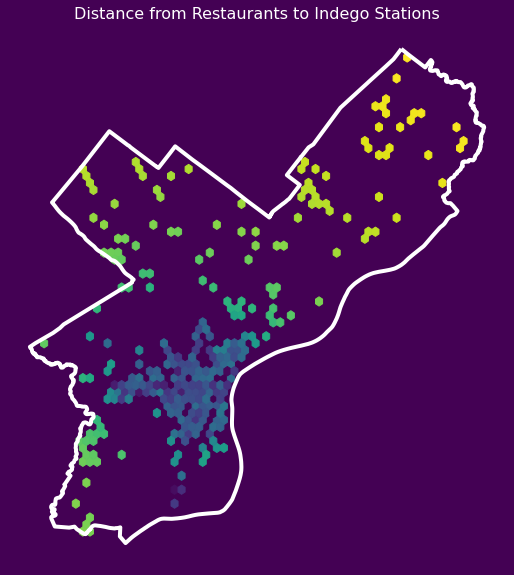

In [146]:
# most basic version, see below for the better product
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = foodXY[:,0]
y = foodXY[:,1]
ax.hexbin(x, y, C=food_and_drink['logDistStation'].values, gridsize=60)

# Plot the city limits
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Restaurants to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('food.png')

Restaurants and bars located in Center City has easier access to Indego bike stations.

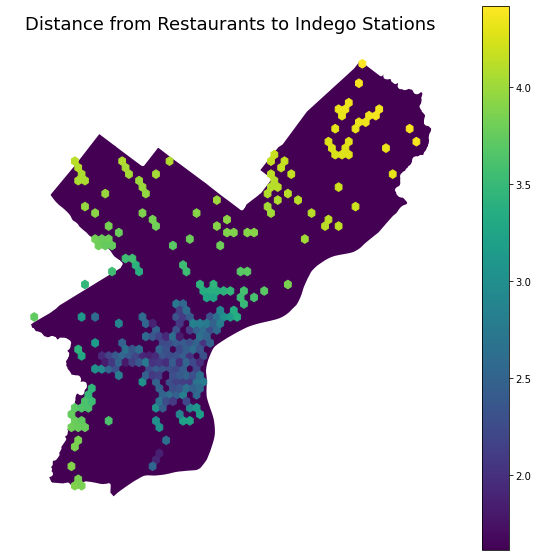

In [24]:
# alternative to the previous map
bounds = city_limits.total_bounds
ex = [bounds[0], bounds[2], bounds[1], bounds[3]]

fig, ax = plt.subplots(figsize=(10,10))


# Plot the city limits
city_limits.plot(ax=ax, facecolor=plt.get_cmap('viridis')(0), edgecolor='white', linewidth=4)

# Plot the log of the subway distance
x = foodXY[:,0]
y = foodXY[:,1]
hex_vals = ax.hexbin(x, y, C=food_and_drink['logDistStation'].values, gridsize=60, extent=ex)

fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_title("Distance from Restaurants to Indego Stations", fontsize=18)
ax.set_aspect("equal")


#### 2. subway station

In [25]:
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry
subway = ox.geometries_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

In [26]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))
# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(stationXY)
# STEP 4: Get distances for sale /restaurant to neighbors /stations
stationDists, stationIndices = nbrs.kneighbors(subwayXY)
# STEP 5: add back to the original dataset
subway["logDistStation"] = np.log10(stationDists[:, 0])

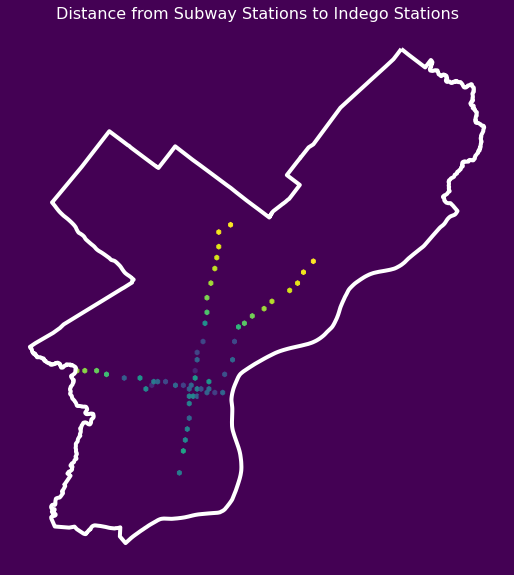

In [147]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = subwayXY[:,0]
y = subwayXY[:,1]
ax.hexbin(x, y, C=subway['logDistStation'].values, gridsize=60)

# Plot the city limits
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Subway Stations to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('subway.png')

#### 3. cafe

In [28]:
cafe = ox.geometries_from_polygon(city_limits_outline, tags={"amenity": "cafe"})

# Convert to 3857 (meters)
cafe = cafe.to_crs(epsg=3857)

In [29]:
cafeXY = get_xy_from_geometry(cafe.to_crs(epsg=3857))
# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)
# STEP 3
nbrs.fit(stationXY)
# STEP 4
stationDists, stationIndices = nbrs.kneighbors(cafeXY)
# STEP 5
cafe["logDistStation"] = np.log10(stationDists[:, 0])

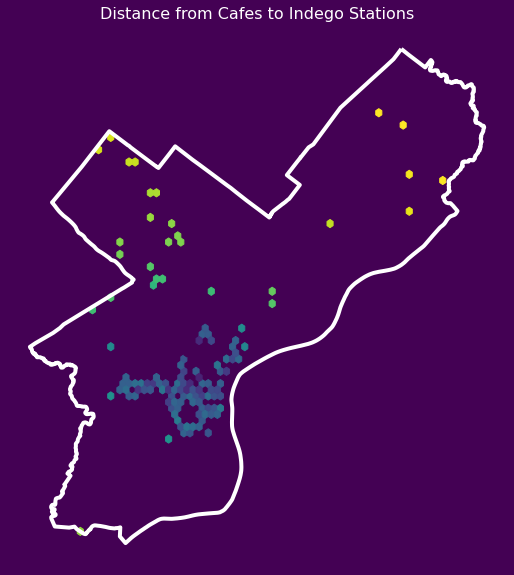

In [149]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = cafeXY[:,0]
y = cafeXY[:,1]
ax.hexbin(x, y, C=cafe['logDistStation'].values, gridsize=60)

# Plot the city limits
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Cafes to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('cafe.png')

#### 4. parks

In [31]:
park = ox.geometries_from_polygon(city_limits_outline, tags={"leisure": "park"})

# Convert to 3857 (meters)
park = park.to_crs(epsg=3857)

In [32]:
parkXY = get_xy_from_geometry(park.to_crs(epsg=3857))
# STEP 2
nbrs = NearestNeighbors(n_neighbors=1)
# STEP 3
nbrs.fit(stationXY)
# STEP 4 - CHANGE
stationDists, stationIndices = nbrs.kneighbors(parkXY)
# STEP 5 - CHANGE
park["logDistStation"] = np.log10(stationDists[:, 0])

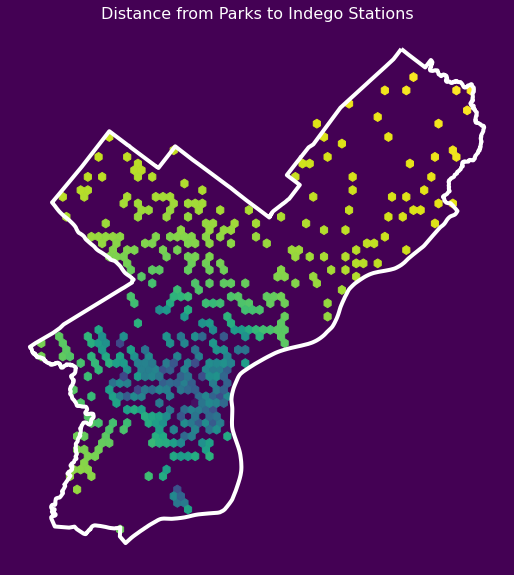

In [150]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = parkXY[:,0]
y = parkXY[:,1]
ax.hexbin(x, y, C=park['logDistStation'].values, gridsize=60)

# Plot the city limits
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Parks to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('park.png')

#### 5. tourist attraction (attractions, museums)

In [34]:
tourist = ox.geometries_from_polygon(city_limits_outline, tags={"tourism": ["attraction","gallery","museum","zoo"]})

# Convert to 3857 (meters)
tourist = tourist.to_crs(epsg=3857)

In [35]:
touristXY = get_xy_from_geometry(tourist.to_crs(epsg=3857))
# STEP 2
nbrs = NearestNeighbors(n_neighbors=1)
# STEP 3
nbrs.fit(stationXY)
# STEP 4 - CHANGE
stationDists, stationIndices = nbrs.kneighbors(touristXY)
# STEP 5 - CHANGE
tourist["logDistStation"] = np.log10(stationDists[:, 0])

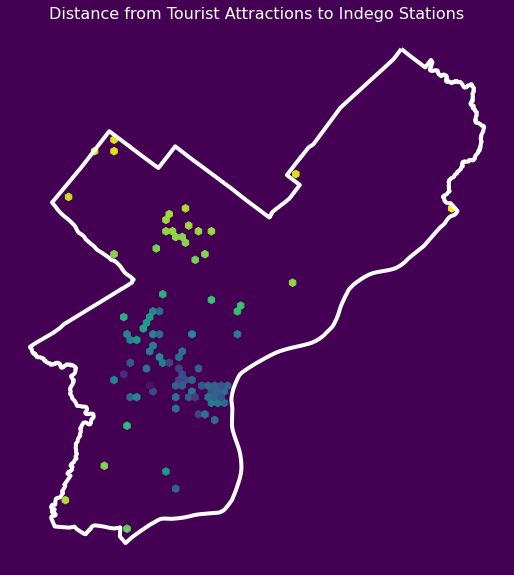

In [151]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = touristXY[:,0]
y = touristXY[:,1]
ax.hexbin(x, y, C=tourist['logDistStation'].values, gridsize=60)

# Plot the city limits
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Tourist Attractions to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('tour.png')

#### 6. bus station (SEPTA spring 2019 stops by route)

In [37]:
url = "https://opendata.arcgis.com/datasets/e09e9f98bdf04eada214d2217f3adbf1_0.geojson"
bus = gpd.read_file(url).to_crs(epsg=3857)

In [38]:
bus_phl = gpd.sjoin(bus, city_limits, op='within', how='inner') 
bus_phl

,OBJECTID_left,GIS_DB_ID,Sign_Up,Route,Direction,Sequence,Stop_ID,Stop_Abbreviation,Stop_Name,Mode,...,Sunday_Boards,Sunday_Leaves,Latitude,Longitude,GlobalID,geometry,index_right,OBJECTID_right,Shape__Area,Shape__Length
0,1,6722579N,City,67,Northbound,134,22579,KNIPATNE,Knights Rd & Patrician Dr,Bus,...,0.0,1.0,40.081350,-74.976152,07f518b8-0f98-4724-a565-c1263d9fa051,POINT (-8346307.062 4877770.891),0,1,0.038911,1.259687
2,3,89220W,City,89,Westbound,1,220,ARRTRAWE,Arrott Transportation Center,Bus,...,50.0,0.0,40.016869,-75.084202,b12b9a79-c942-4e78-8b27-508e4da6d71a,POINT (-8358335.133 4868393.939),0,1,0.038911,1.259687
3,4,3131044E,City,31,Eastbound,24,31044,MAR61SEA,Market St & 61st St - FS,Bus,...,2.0,6.0,39.962057,-75.242564,6f5aa081-1c66-4a7f-a47b-36c9f280feea,POINT (-8375963.910 4860430.037),0,1,0.038911,1.259687
5,6,2521970N,City,25,Northbound,99,21970,FTC 25,Frankford Transportation Center - Rt 25,Bus,...,0.0,65.0,40.023444,-75.077031,73f653b4-81c2-4539-befc-e11094fe923a,POINT (-8357536.861 4869349.683),0,1,0.038911,1.259687
6,7,1721294N,City,17,Northbound,24,21294,20TJACNO,20th St & Jackson St,Bus,...,33.0,5.0,39.924284,-75.179450,688573b3-4c9c-437f-92a7-8c6f4be690a6,POINT (-8368938.092 4854945.529),0,1,0.038911,1.259687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21694,21695,58874N,City,58,Northbound,98,874,BUSCOUNE,Bustleton Av & County Line,Bus,...,0.0,0.0,40.134224,-75.009168,b8a26a1f-d849-4cfd-9a32-0152812f47bb,POINT (-8349982.387 4885466.559),0,1,0.038911,1.259687
21695,21696,730103N,City,7,Northbound,105,30103,29TRIDNO,29th St & Ridge Av,Bus,...,8.0,16.0,39.986654,-75.180768,9bbea4ae-5400-4ee9-9180-8ef870291c6d,POINT (-8369084.811 4864003.065),0,1,0.038911,1.259687
21696,21697,6424631E,City,64,Eastbound,35,24631,49TBALSE,49th St & Baltimore Av - FS,Bus,...,17.0,6.0,39.947957,-75.221133,c50a5f01-7aaf-4b16-a395-48b01110652a,POINT (-8373578.222 4858382.412),0,1,0.038911,1.259687
21697,21698,5711468S,City,57,Southbound,130,11468,ORE4THEA,Oregon Av & 4th St - FS,Bus,...,NaN,NaN,39.914594,-75.154839,37ff856e-6af2-41d7-97e2-13075f7c4574,POINT (-8366198.408 4853539.063),0,1,0.038911,1.259687


In [39]:
busXY = get_xy_from_geometry(bus_phl.to_crs(epsg=3857))
# STEP 2
nbrs = NearestNeighbors(n_neighbors=1)
# STEP 3
nbrs.fit(stationXY)
# STEP 4 - CHANGE
stationDists, stationIndices = nbrs.kneighbors(busXY)
# STEP 5 - CHANGE
bus_phl["logDistStation"] = np.log10(stationDists[:, 0])

In [40]:
len(busXY)

13988

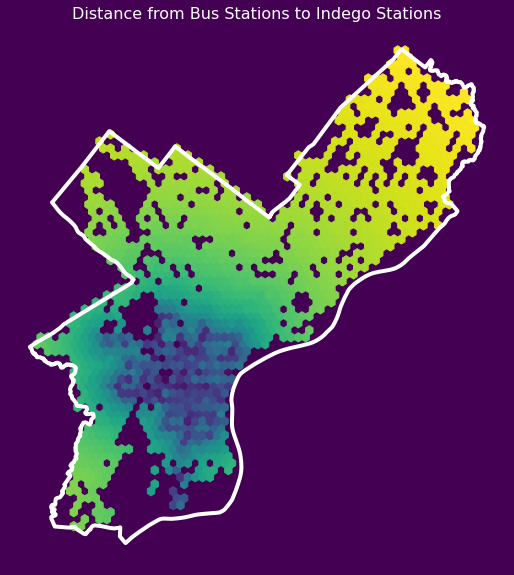

In [152]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# CHANGE
x = busXY[:,0]
y = busXY[:,1]
ax.hexbin(x, y, C=bus_phl['logDistStation'].values, gridsize=60)

# NO CHANGE
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Bus Stations to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('bus.png')

#### 7. supermarket

In [42]:
supermkt = ox.geometries_from_polygon(city_limits_outline, tags={"shop": "supermarket"})

# Convert to 3857 (meters)
supermkt = supermkt.to_crs(epsg=3857)

In [43]:
supermktXY = get_xy_from_geometry(supermkt.to_crs(epsg=3857))
# STEP 2
nbrs = NearestNeighbors(n_neighbors=1)
# STEP 3
nbrs.fit(stationXY)
# STEP 4 - CHANGE
stationDists, stationIndices = nbrs.kneighbors(supermktXY)
# STEP 5 - CHANGE
supermkt["logDistStation"] = np.log10(stationDists[:, 0])

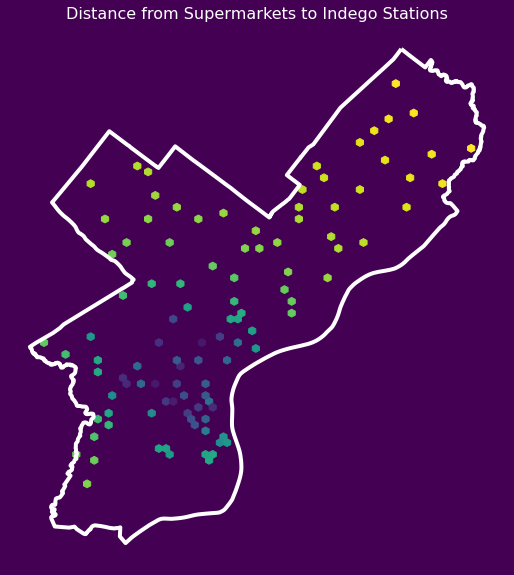

In [153]:
fig, ax = plt.subplots(figsize=(10,10), facecolor=plt.get_cmap('viridis')(0))

# Plot the log of the subway distance
x = supermktXY[:,0]
y = supermktXY[:,1]
ax.hexbin(x, y, C=supermkt['logDistStation'].values, gridsize=60)

# Plot the city limits
phl_bound_map = city_limits.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=4)

ax.set_axis_off()
ax.set_aspect("equal")
ax.set_title(
    "Distance from Supermarkets to Indego Stations", fontsize=16, color="white"
);
#plt.savefig('supermarket.png')

## machine learning model

1. get all the **ending** stations and plot to see the distribution

In [45]:
start_trips = (
    bike_trips.groupby("start_station").size().reset_index(name="total_start_trips")
)
start_trips.head()

,start_station,total_start_trips
0,3000,491
1,3004,15566
2,3005,10718
3,3006,13420
4,3007,27993


In [46]:
bike = (
    station[["geometry", "kioskId"]]
    .merge(start_trips, left_on="kioskId", right_on="start_station")
    .to_crs(epsg=3857)
)

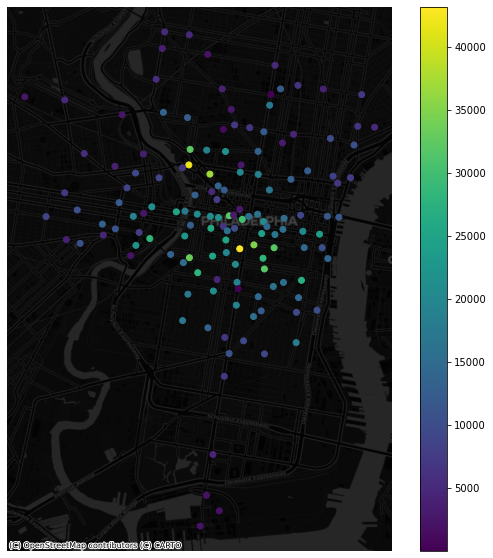

In [155]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike.plot(ax=ax, column='total_start_trips', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()
plt.savefig('start_trip.png')

trips mostly end around neighborhoods in center city and south philly
## 2. load in variables for prediction
### 2.1 internal - number of docks

In [48]:
bike = bike.merge(station[["kioskId", "totalDocks"]], on="kioskId")
bike.head()

,geometry,kioskId,start_station,total_start_trips,totalDocks
0,POINT (-8367189.263 4859227.987),3004,3004,15566,30
1,POINT (-8364995.156 4858291.368),3005,3005,10718,13
2,POINT (-8371571.911 4858998.543),3006,3006,13420,17
3,POINT (-8366765.136 4857977.729),3007,3007,27993,20
4,POINT (-8365720.959 4863149.674),3008,3008,6316,19


### 2.2 amenities

In [49]:
stationsXY = get_xy_from_geometry(bike)

In [50]:
# 1 - food
# STEP 1: x/y coordinates of restaurants (in EPGS=3857)
restsXY = get_xy_from_geometry(food_and_drink.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(restsXY)

# STEP 4: Get distances for stations to neighbors
restsDists, restsIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistRests'] = np.log10(restsDists.mean(axis=1))

In [51]:
# 2 - subway
subwXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# no change
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: CHANGE TO ___XY
nbrs.fit(subwXY)

# STEP 4: Get distances for stations to neighbors
subwDists, subwIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistSubw'] = np.log10(subwDists.mean(axis=1))

In [52]:
# 3 - cafe
cafXY = get_xy_from_geometry(cafe.to_crs(epsg=3857))

# no change
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: CHANGE TO ___XY
nbrs.fit(cafXY)

# STEP 4: Get distances for stations to neighbors
cafDists, cafIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistCaf'] = np.log10(cafDists.mean(axis=1))

In [53]:
# 4 - park
pkXY = get_xy_from_geometry(park.to_crs(epsg=3857))

# no change
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: CHANGE TO ___XY
nbrs.fit(pkXY)

# STEP 4: Get distances for stations to neighbors
pkDists, pkIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistPk'] = np.log10(pkDists.mean(axis=1))

In [54]:
# 5 - tourist attration
tourXY = get_xy_from_geometry(tourist.to_crs(epsg=3857))

# no change
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: CHANGE TO ___XY
nbrs.fit(tourXY)

# STEP 4: Get distances for stations to neighbors
tourDists, tourIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistTour'] = np.log10(tourDists.mean(axis=1))

In [55]:
# 6 - SEPTA bus station
septaXY = get_xy_from_geometry(bus_phl.to_crs(epsg=3857))

# no change
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: CHANGE TO ___XY
nbrs.fit(septaXY)

# STEP 4: Get distances for stations to neighbors
septaDists, septaIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistBus'] = np.log10(septaDists.mean(axis=1))

In [56]:
# 7 - supermarket
smktXY = get_xy_from_geometry(supermkt.to_crs(epsg=3857))

# no change
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: CHANGE TO ___XY
nbrs.fit(smktXY)

# STEP 4: Get distances for stations to neighbors
smktDists, smktIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logDistSupermkt'] = np.log10(septaDists.mean(axis=1))

In [57]:
bike.head()

,geometry,kioskId,start_station,total_start_trips,totalDocks,logDistRests,logDistSubw,logDistCaf,logDistPk,logDistTour,logDistBus,logDistSupermkt
0,POINT (-8367189.263 4859227.987),3004,3004,15566,30,2.577713,2.800316,2.569290,2.790533,2.898244,2.056463,2.056463
1,POINT (-8364995.156 4858291.368),3005,3005,10718,13,2.114143,3.127048,2.620344,2.570733,2.476786,2.229985,2.229985
2,POINT (-8371571.911 4858998.543),3006,3006,13420,17,2.392691,3.262987,2.762148,2.909963,3.243412,2.265570,2.265570
3,POINT (-8366765.136 4857977.729),3007,3007,27993,20,2.543998,2.930125,2.662572,2.786677,2.875102,2.195092,2.195092
4,POINT (-8365720.959 4863149.674),3008,3008,6316,19,2.741634,3.305460,2.800412,2.929817,3.454668,2.521896,2.521896


### 2.3 if nearby has bike lane

In [58]:
# #command + / for all hashtag

# import requests
# lane_url = "http://data.phl.opendata.arcgis.com/datasets/b5f660b9f0f44ced915995b6d49f6385_0.geojson"
# blane = gpd.read_file(lane_url).to_crs(epsg=4326)
# blane.head()

In [59]:
# buffered_station = bike.copy()
# buffered_station = buffered_station.to_crs(epsg=4326)

# ### create buffer of 10m within station
# buffered_station['geometry'] = buffered_station.buffer(10)


In [60]:
# buffered_station['bike_lane_10m'] = buffered_station.geometry.intersects(blane).astype(int)

In [61]:
# sum(buffered_station['bike_lane_10m'])

In [62]:

# intersect = buffered_station.loc[buffered_station.intersects(blane)]

# #result: bike lane all around bike stations, not predictive at all

In [63]:
# cycle = pd.merge(bike, buffered_station, on='kioskId', how='left')
# cycle.head()

### 2.4 neighboring stations - spatial lag

In [64]:
N = 5
k = N + 1
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(stationsXY)

stationDists, stationIndices = nbrs.kneighbors(stationsXY)

In [65]:
bike["logNearStationDists"] = np.log10(stationDists[:, 1:].mean(axis=1))

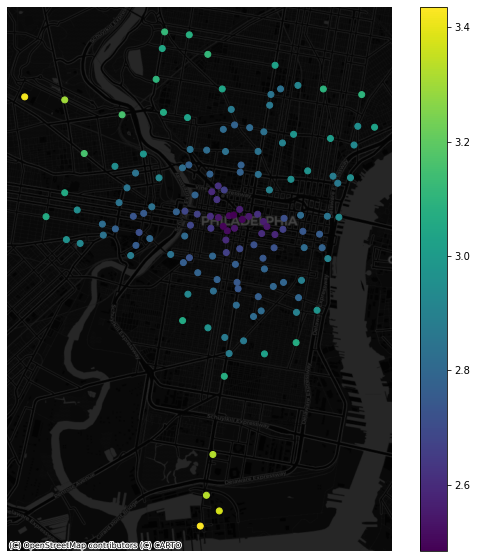

In [66]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike.plot(ax=ax, column='logNearStationDists', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

In [67]:
stationIndices[:, 1:]

array([[ 80,  29, 129, 133,  14],
       [ 38,  36,  11,  37, 114],
       [ 97, 104, 105,  63,  19],
       [ 75,  41,  35, 112,   6],
       [ 24,  13, 142, 138,  45],
       [135,  22,  18, 136,  60],
       [ 52,  35,  95, 124, 130],
       [105,  28,  56,  22, 135],
       [ 25, 115, 131,  55,  85],
       [ 62, 125,  59,  12,  54],
       [ 87, 122,  49, 110,  43],
       [ 37,   1,  36,  38,  44],
       [ 54,  31,  64,  65,  62],
       [  4,  71,  24,  68, 111],
       [120,  29, 112,   0,  26],
       [ 37,  39,  44, 114,  36],
       [136,  30, 119, 135, 107],
       [133,  66, 134, 129, 130],
       [106,  51,  50,   5, 110],
       [137,  97,   2,  63, 104],
       [ 72,  23,  27, 141,  57],
       [ 58, 100,  23,  73,  11],
       [135, 136, 105,   5, 104],
       [100,  20,  75,  72,  58],
       [142,   4,  45, 138,  13],
       [115,   8, 107, 108,  55],
       [ 44, 120,  41, 112,  14],
       [ 72,  20,  57, 109, 141],
       [  7,  77,  56,  60, 105],
       [  0,  

In [68]:
# the total trips for the stations from original data frame
total_start_trips = bike['total_start_trips'].values

In [69]:
# get the trips for the 5 nearest neighbors (ignoring first match)
neighboring_trips = total_start_trips[stationIndices[:, 1:]]

In [70]:
neighboring_trips

array([[30252, 16447,  2870,  3225, 20544],
       [13858, 24118, 14803, 20187, 11783],
       [ 4680, 11435, 12379, 10561, 10431],
       [32132, 31888, 35044, 24944, 43130],
       [12129,  3973,    43,  4903, 17165],
       [ 2434, 19507, 25531,  7887,  9042],
       [19803, 35044, 21015, 25316,  9946],
       [12379,  9184,  3847, 19507,  2434],
       [33281, 15058,  4647, 25468, 16950],
       [12933,  8019,  6899,  3100,  4463],
       [13859,  7913, 12275, 13219, 37025],
       [20187, 10718, 24118, 13858, 15942],
       [ 4463, 12143, 13632,  6591, 12933],
       [ 6316,  7078, 12129,  9905,  6571],
       [14555, 16447, 24944, 15566, 16971],
       [20187, 15173, 15942, 11783, 24118],
       [ 7887, 21773,  1920,  2434, 13556],
       [ 3225, 22032,  6751,  2870,  9946],
       [17159, 12806, 21114, 21463, 13219],
       [ 3768,  4680, 13420, 10561, 11435],
       [12184, 16455, 15554,   151, 18792],
       [14382, 15856, 16455,  9676, 14803],
       [ 2434,  7887, 12379, 214

In [71]:
# Add to features
bike['laggedTrips'] = neighboring_trips.mean(axis=1)

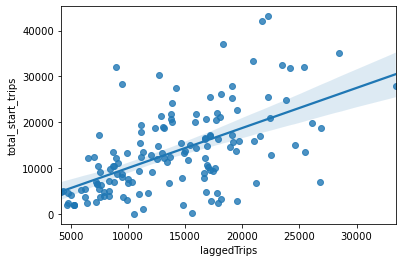

In [72]:
sns.regplot(bike['laggedTrips'], bike['total_start_trips']);

### 2.5 census data
https://api.census.gov/data/2018/acs/acs5/variables.html
1. median household income <br>
https://api.census.gov/data/2018/acs/acs5/variables/B19013_001E.json
"name": "B19013_001E",
  "label": "Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars)",
  "concept": "MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)",

In [73]:
import cenpy
acs = cenpy.remote.APIConnection("ACSDT5Y2018")

/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [74]:
variables = ["NAME", "B19013_001E"]

# Pull data by census tract
census_income = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": "42",
                "county": "101", 
                "tract": "*"},
)

# Convert to the data to floats
for col in variables[1:]:
    census_income[col] = census_income[col].astype(float)
    census_income['medhhincome'] = census_income['B19013_001E']


In [75]:
census_income.head()

,NAME,B19013_001E,state,county,tract,block group,medhhincome
0,"Block Group 3, Census Tract 288, Philadelphia ...",24427.0,42,101,028800,3,24427.0
1,"Block Group 1, Census Tract 288, Philadelphia ...",25489.0,42,101,028800,1,25489.0
2,"Block Group 2, Census Tract 298, Philadelphia ...",-666666666.0,42,101,029800,2,-666666666.0
3,"Block Group 4, Census Tract 298, Philadelphia ...",25172.0,42,101,029800,4,25172.0
4,"Block Group 3, Census Tract 298, Philadelphia ...",37333.0,42,101,029800,3,37333.0


In [76]:
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [77]:
acs.mapservice.layers[10]

(ESRILayer) Census Block Groups

In [78]:
# Use SQL to return geometries only for Philadelphia County in PA
where_clause = "STATE = 42 AND COUNTY = 101"

# Query for tracts
block_groups = acs.mapservice.layers[10].query(where=where_clause)

/Users/chzhang03/miniconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [79]:
census_income = block_groups.merge(
    census_income,
    left_on=["STATE", "COUNTY", "TRACT", "BLKGRP"],
    right_on=["state", "county", "tract", "block group"],
)

In [80]:
census_income.head()

,MTFCC,OID,GEOID,STATE,COUNTY,TRACT,BLKGRP,BASENAME,NAME_x,LSADC,...,STGEOMETRY.AREA,STGEOMETRY.LEN,geometry,NAME_y,B19013_001E,state,county,tract,block group,medhhincome
0,G5030,20858508931877,421010355002,42,101,035500,2,2,Block Group 2,BG,...,9.186724e+05,4215.789689,"POLYGON ((-8353106.345 4878406.706, -8353053.5...","Block Group 2, Census Tract 355, Philadelphia ...",45994.0,42,101,035500,2,45994.0
1,G5030,20858508931779,421010355003,42,101,035500,3,3,Block Group 3,BG,...,1.791745e+06,8235.537680,"POLYGON ((-8353580.232 4878642.128, -8353218.1...","Block Group 3, Census Tract 355, Philadelphia ...",40625.0,42,101,035500,3,40625.0
2,G5030,20858508932434,421010356011,42,101,035601,1,1,Block Group 1,BG,...,1.464185e+06,6290.193745,"POLYGON ((-8354256.944 4879308.848, -8354227.1...","Block Group 1, Census Tract 356.01, Philadelph...",51765.0,42,101,035601,1,51765.0
3,G5030,20858508932102,421010356022,42,101,035602,2,2,Block Group 2,BG,...,1.472942e+06,5987.640635,"POLYGON ((-8355008.796 4881749.699, -8354858.9...","Block Group 2, Census Tract 356.02, Philadelph...",78021.0,42,101,035602,2,78021.0
4,G5030,208583717019680,421010386001,42,101,038600,1,1,Block Group 1,BG,...,5.712645e+06,15897.046276,"POLYGON ((-8373602.156 4876473.490, -8373704.5...","Block Group 1, Census Tract 386, Philadelphia ...",129417.0,42,101,038600,1,129417.0


In [81]:
bike = gpd.sjoin(
    bike,
    census_income.to_crs(bike.crs)[["geometry", "medhhincome"]],
    op="within",
).drop(labels=['index_right'], axis=1)

In [82]:
bike.head()

,geometry,kioskId,start_station,total_start_trips,totalDocks,logDistRests,logDistSubw,logDistCaf,logDistPk,logDistTour,logDistBus,logDistSupermkt,logNearStationDists,laggedTrips,medhhincome
0,POINT (-8367189.263 4859227.987),3004,3004,15566,30,2.577713,2.800316,2.569290,2.790533,2.898244,2.056463,2.056463,2.545438,14667.6,78945.0
17,POINT (-8367777.030 4859245.413),3021,3021,32081,34,2.477550,2.903964,2.527499,2.640837,2.886265,1.899876,1.899876,2.503991,8964.8,78945.0
80,POINT (-8367386.298 4859137.951),3108,3108,30252,22,2.570156,2.799099,2.437838,2.717286,2.883685,1.820183,1.820183,2.497364,12737.6,78945.0
130,POINT (-8367616.730 4858873.658),3202,3202,9946,21,2.225458,2.835554,2.396401,2.792445,2.873777,2.060927,2.060927,2.537762,17618.8,78945.0
133,POINT (-8367644.560 4859267.196),3205,3205,3225,20,2.524628,2.878934,2.479130,2.608591,2.889329,1.401553,1.401553,2.484050,18143.0,78945.0


In [83]:
missing = bike['medhhincome'].isnull()
bike.loc[missing, 'medhhincome'] = bike['medhhincome'].median()

2. percentage of car ownership

In [84]:
# Means of Transportation to Work by Travel Time to Work
variables = ["NAME", "B08134_001E", "B08134_011E"]

# Pull data by census tract
census_carown = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": "42",
                "county": "101", 
                "tract": "*"},
)

# Convert to the data to floats
for col in variables[1:]:
    census_carown[col] = census_carown[col].astype(float)

# The percent commuting by car
census_carown["percent_car"] = census_carown["B08134_011E"] / census_carown["B08134_001E"]

In [85]:
census_carown = block_groups.merge(
    census_carown,
    left_on=["STATE", "COUNTY", "TRACT", "BLKGRP"],
    right_on=["state", "county", "tract", "block group"],
)

In [86]:
bike = gpd.sjoin(
    bike,
    census_carown.to_crs(bike.crs)[["geometry", "percent_car"]],
    op="within",
).drop(labels=['index_right'], axis=1)

In [87]:
missing = bike['percent_car'].isnull()
bike.loc[missing, 'percent_car'] = bike['percent_car'].median()

### 2.6 within the center city business district

In [88]:
import osmnx as ox

In [89]:
url = "http://data.phl.opendata.arcgis.com/datasets/95366b115d93443eae4cc6f498cb3ca3_0.geojson"
ccbd = gpd.read_file(url).to_crs(epsg=3857)

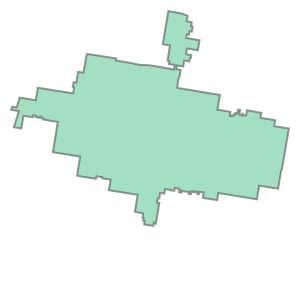

In [90]:
ccbd_geo = ccbd.squeeze().geometry

ccbd_geo

In [91]:
# Add the new feature: 1 if within CC and 0 otherwise
bike['within_centerCity'] = bike.geometry.within(ccbd_geo).astype(int)

### 2.7 distance to nearest transportation intersections

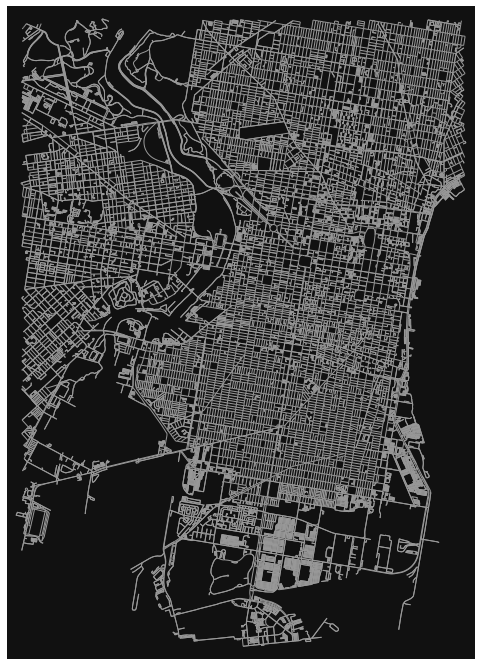

In [92]:
xmin, ymin, xmax, ymax = bike.to_crs(epsg=4326).total_bounds

G = ox.graph_from_bbox(ymax, ymin, xmax, xmin, network_type='bike')

ox.plot_graph(G, figsize=(12, 12), node_size=0);

In [93]:
interesections = ox.graph_to_gdfs(G, nodes=True, edges=False).to_crs(epsg=3857)
interesections.head()

,y,x,osmid,highway,geometry
109727072,39.920114,-75.176365,109727072,NaN,POINT (-8368594.627 4854340.318)
109727084,39.918876,-75.176639,109727084,NaN,POINT (-8368625.162 4854160.598)
109727165,39.917601,-75.176933,109727165,NaN,POINT (-8368657.901 4853975.496)
109727173,39.917476,-75.176959,109727173,NaN,POINT (-8368660.784 4853957.411)
109727183,39.917126,-75.177038,109727183,NaN,POINT (-8368669.590 4853906.554)


In [94]:
# STEP 1: x/y coordinates of restaurants (in EPGS=3857)
intersectionsXY = get_xy_from_geometry(interesections.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=10)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(intersectionsXY)

# STEP 4: Get distances for stations to neighbors
interDists, interIndices = nbrs.kneighbors(stationsXY)

# STEP 5: add back to the original dataset
bike['logIntersectionDists'] = np.log10(interDists.mean(axis=1))

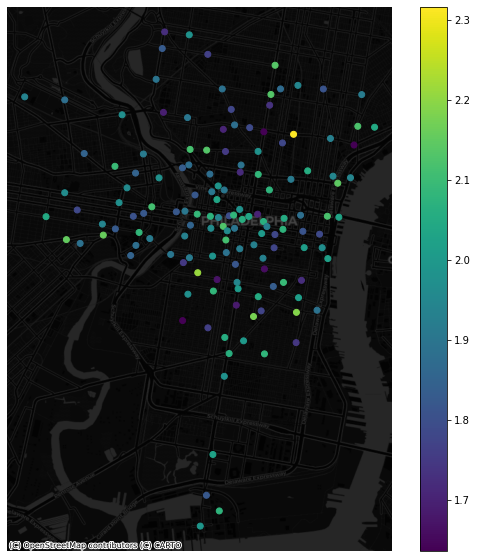

In [95]:
fig, ax = plt.subplots(figsize=(10,10))

# stations
bike.plot(ax=ax, column='logIntersectionDists', legend=True)

# plot the basemap underneath
ctx.add_basemap(ax=ax, crs=bike.crs, source=ctx.providers.CartoDB.DarkMatter)

ax.set_axis_off()

In [96]:
bike.head()

,geometry,kioskId,start_station,total_start_trips,totalDocks,logDistRests,logDistSubw,logDistCaf,logDistPk,logDistTour,logDistBus,logDistSupermkt,logNearStationDists,laggedTrips,medhhincome,percent_car,within_centerCity,logIntersectionDists
0,POINT (-8367189.263 4859227.987),3004,3004,15566,30,2.577713,2.800316,2.569290,2.790533,2.898244,2.056463,2.056463,2.545438,14667.6,78945.0,0.342105,1,2.038873
17,POINT (-8367777.030 4859245.413),3021,3021,32081,34,2.477550,2.903964,2.527499,2.640837,2.886265,1.899876,1.899876,2.503991,8964.8,78945.0,0.342105,1,1.798067
80,POINT (-8367386.298 4859137.951),3108,3108,30252,22,2.570156,2.799099,2.437838,2.717286,2.883685,1.820183,1.820183,2.497364,12737.6,78945.0,0.342105,1,2.063213
130,POINT (-8367616.730 4858873.658),3202,3202,9946,21,2.225458,2.835554,2.396401,2.792445,2.873777,2.060927,2.060927,2.537762,17618.8,78945.0,0.342105,1,1.899754
133,POINT (-8367644.560 4859267.196),3205,3205,3225,20,2.524628,2.878934,2.479130,2.608591,2.889329,1.401553,1.401553,2.484050,18143.0,78945.0,0.342105,1,2.079953


## 3. correlation for all variables

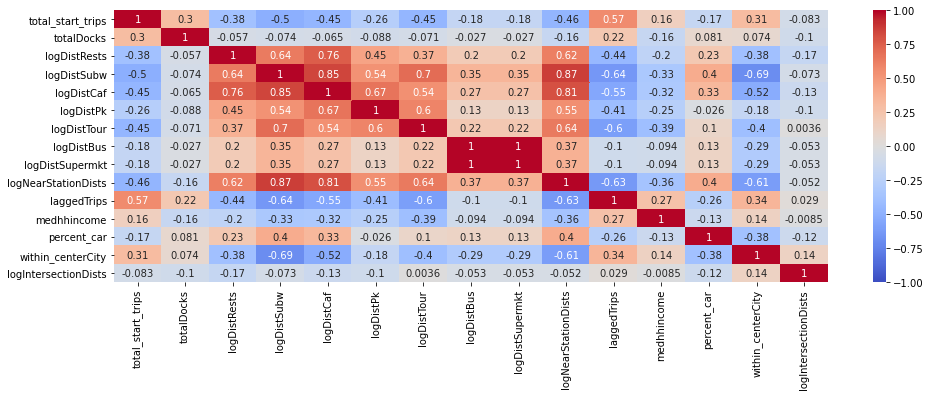

In [157]:
feature_cols = [
    "total_start_trips",
    "totalDocks",
    "logDistRests",
    "logDistSubw",
    "logDistCaf",
    "logDistPk",
    "logDistTour",
    "logDistBus",
    "logDistSupermkt",
    "logNearStationDists",
    "laggedTrips",
    "medhhincome",
    "percent_car",
    "within_centerCity",
    "logIntersectionDists"
]

plt.figure(figsize = (16,5))
sns.heatmap(
    bike[feature_cols].corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1
)
#plt.savefig('correlation1.png')

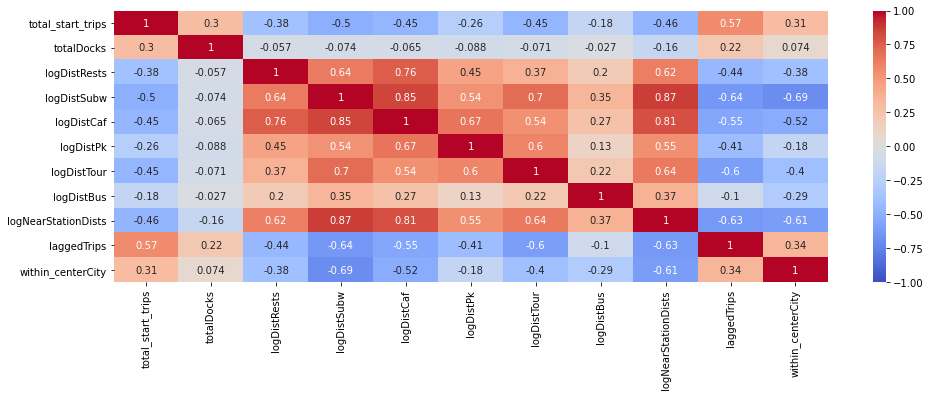

In [238]:
# improved
feature_cols = [
    "total_start_trips",
    "totalDocks",
    "logDistRests",
    "logDistSubw",
    "logDistCaf",
    "logDistPk",
    "logDistTour",
    "logDistBus",
    #"logDistSupermkt",
    "logNearStationDists",
    "laggedTrips",
    "within_centerCity"
]

plt.figure(figsize = (16,5))
sns.heatmap(
    bike[feature_cols].corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1
)
#plt.savefig('correlation2.png')

potentially add more variables to see the correlation

## 4. fit a model to predict trip destination

In [239]:
bike.head()

,geometry,kioskId,start_station,total_start_trips,totalDocks,logDistRests,logDistSubw,logDistCaf,logDistPk,logDistTour,logDistBus,logDistSupermkt,logNearStationDists,laggedTrips,medhhincome,percent_car,within_centerCity,logIntersectionDists
0,POINT (-8367189.263 4859227.987),3004,3004,15566,30,2.577713,2.800316,2.569290,2.790533,2.898244,2.056463,2.056463,2.545438,14667.6,78945.0,0.342105,1,2.038873
17,POINT (-8367777.030 4859245.413),3021,3021,32081,34,2.477550,2.903964,2.527499,2.640837,2.886265,1.899876,1.899876,2.503991,8964.8,78945.0,0.342105,1,1.798067
80,POINT (-8367386.298 4859137.951),3108,3108,30252,22,2.570156,2.799099,2.437838,2.717286,2.883685,1.820183,1.820183,2.497364,12737.6,78945.0,0.342105,1,2.063213
130,POINT (-8367616.730 4858873.658),3202,3202,9946,21,2.225458,2.835554,2.396401,2.792445,2.873777,2.060927,2.060927,2.537762,17618.8,78945.0,0.342105,1,1.899754
133,POINT (-8367644.560 4859267.196),3205,3205,3225,20,2.524628,2.878934,2.479130,2.608591,2.889329,1.401553,1.401553,2.484050,18143.0,78945.0,0.342105,1,2.079953


In [240]:
# Remove unnecessary columns
bike_features = bike.drop(labels=["geometry", "kioskId", "start_station"], axis=1)

In [241]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

# Neighbors
from sklearn.neighbors import NearestNeighbors

In [242]:
# Split the data 
train_set, test_set = train_test_split(
    bike_features,
    test_size=0.3,
    random_state=12345,
)

# the target labels: log of total start trips
y_train = np.log(train_set["total_start_trips"])
y_test = np.log(test_set["total_start_trips"])

In [253]:
feature_cols = [
    "totalDocks",
    "logDistRests",
    "logDistSubw",
    "logDistCaf",
    "logDistPk",
    "logDistTour",
    "logDistBus",
    #"logDistSupermkt",
    "logNearStationDists",
    "laggedTrips",
    "within_centerCity"
]

train_set = train_set[feature_cols]
test_set = test_set[feature_cols]

### 4.2 random forest results

In [254]:
# Setup the pipeline with a standard scaler
pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(random_state=42)
)

In [255]:
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 10, 15, 20, 30],
    f"{model_name}__max_depth": [None, 2, 5, 7, 9, 13],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30],
 'randomforestregressor__max_depth': [None, 2, 5, 7, 9, 13]}

In [256]:
# Create the grid and use 5-fold CV
grid = GridSearchCV(pipe, param_grid, cv=5)

# Run the search
grid.fit(train_set, y_train);

In [257]:
grid.best_params_

{'randomforestregressor__max_depth': 7,
 'randomforestregressor__n_estimators': 15}

In [258]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
grid.score(test_set, y_test)

0.40827975407227945

In [268]:
# Set up a linear pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(train_set, y_train)

# Evaluate on test set
linear.score(test_set, y_test)

0.14404134680763236

### 4.3 shows the most important feature

In [265]:
# The best model
regressor = grid.best_estimator_["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": train_set.columns, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False)

# Plot
important_chart = importance.hvplot.barh(x="Feature", y="Importance", flip_yaxis=True, height=300)
important_chart

:Bars   [Feature]   (Importance)

In [266]:
#hvplot.save(important_chart, 'importance.html')

In [267]:
importance

,Feature,Importance
0,totalDocks,0.265355
7,logNearStationDists,0.263832
8,laggedTrips,0.144443
3,logDistCaf,0.066713
1,logDistRests,0.063484
5,logDistTour,0.060863
4,logDistPk,0.060776
6,logDistBus,0.042748
2,logDistSubw,0.031702
9,within_centerCity,0.000085


### 4.4 analyze the spatial structure of the predictions visually

In [270]:
test_set.index

Int64Index([ 65,   9, 131, 114, 142,  29, 128,  64,  24,  21,  10,  60,  44,
             69,  86,  75, 139, 133,  28, 132, 118,  11,  94,  33,  89,  92,
             59, 135,  45,  87,  84, 108,  18,  93,  95,  50, 120,  32,   3,
             47,  54, 112, 113],
           dtype='int64')

In [271]:
# Extract the test data from the original dataset
# This will include the geometry data
X = bike.loc[test_set.index]

# test data extracted from our original data frame
X.head()

,geometry,kioskId,start_station,total_start_trips,totalDocks,logDistRests,logDistSubw,logDistCaf,logDistPk,logDistTour,logDistBus,logDistSupermkt,logNearStationDists,laggedTrips,medhhincome,percent_car,within_centerCity,logIntersectionDists
65,POINT (-8367163.659 4861884.398),3077,3077,6591,19,2.901007,3.288458,3.146092,2.945712,3.212548,2.193635,2.193635,2.809106,7293.4,50299.0,0.531722,0,1.788524
9,POINT (-8365428.189 4860591.687),3013,3013,12474,17,2.652544,3.200135,3.008600,2.839742,3.183589,2.431740,2.431740,2.964495,7082.8,40500.0,0.565826,0,2.058180
131,POINT (-8368138.818 4857338.867),3203,3203,4647,20,2.793366,3.187260,2.875157,2.883845,3.102404,2.397338,2.397338,2.774754,17822.2,89375.0,0.303972,0,1.668564
114,POINT (-8364839.308 4859233.795),3169,3169,11783,17,2.716273,3.122059,2.798754,2.744866,2.609653,2.412167,2.412167,2.851079,15261.4,101688.0,0.457799,0,2.120017
142,POINT (-8366528.025 4862878.011),3214,3214,43,7,2.123574,3.314269,2.834678,2.915547,3.394807,1.618360,1.618360,2.848561,10531.2,23305.0,0.318244,0,2.135249


In [272]:
# Predictions for log of total trip counts
log_predictions = grid.best_estimator_.predict(test_set)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)

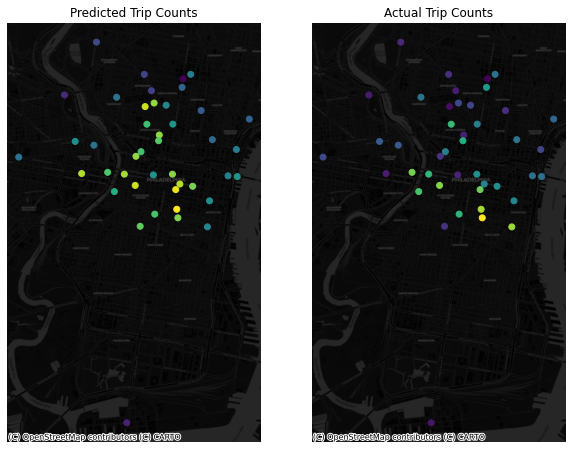

In [273]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(10,10))

# Predicted values
X.plot(ax=axs[0], column='prediction')
ctx.add_basemap(ax=axs[0], crs=X.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[0].set_title("Predicted Trip Counts")

# Actual values
X.plot(ax=axs[1], column='total_start_trips')
ctx.add_basemap(ax=axs[1], crs=X.crs, source=ctx.providers.CartoDB.DarkMatter)
axs[1].set_title("Actual Trip Counts")


axs[0].set_axis_off()
axs[1].set_axis_off()
plt.savefig('prediction.png')